In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
import plotly.graph_objs as go
import plotly.express as px
import math

# COVID ANALYSIS

In [2]:
##### uploading covid data per county
cov = pd.read_csv('covid_us_county.csv')
cov.head()

,fips,county,state,lat,long,date,cases,state_code,deaths
0,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-22,0,AL,0
1,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-23,0,AL,0
2,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-24,0,AL,0
3,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-25,0,AL,0
4,1001.0,Autauga,Alabama,32.539527,-86.644082,2020-01-26,0,AL,0


In [3]:
##### uploading county population data
pop = pd.read_csv('us_county.csv')
pop.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730
1,1003,Baldwin County,Alabama,AL,101188,106919,42.8,208107,51.376936,30.727479,-87.722564
2,1005,Barbour County,Alabama,AL,13697,12085,39.9,25782,46.873788,31.869581,-85.393210
3,1007,Bibb County,Alabama,AL,12152,10375,39.9,22527,46.055844,32.998628,-87.126475
4,1009,Blount County,Alabama,AL,28434,29211,40.8,57645,50.673953,33.980869,-86.567380


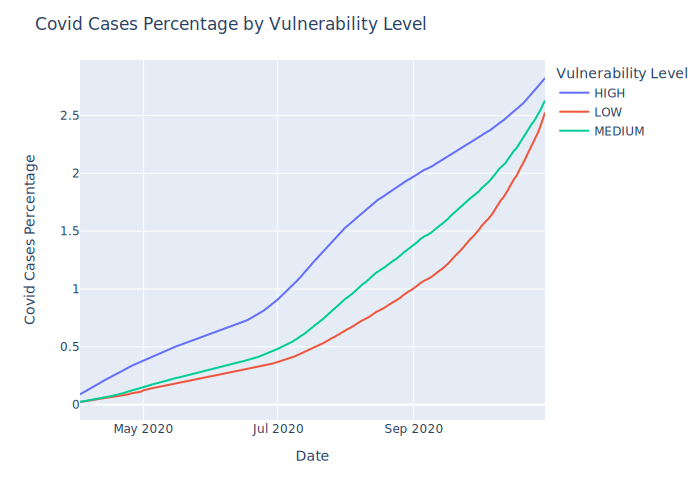

In [4]:
##### calculating the percentage of covid cases
cov2 = cov.merge(pop[['population','fips']],how='left', on=["fips"])
cov2['cov_perc'] = (cov2['cases']/cov2['population'])*100

##### uploading the CDC's SVI data
cvc = pd.read_csv('social_ds.csv')
cvc = cvc[~cvc.eq(-999).any(1)]
cvc.rename(columns={'STCNTY' : 'fips'},inplace=True) 
cvc_ct = cvc.groupby(['fips']).F_TOTAL.sum().reset_index()
##### setting the conditions to create the variable VULNERABILITY LEVEL
conditions = [
    (cvc_ct['F_TOTAL'] <= 3),
    (cvc_ct['F_TOTAL'] > 3) & (cvc_ct['F_TOTAL'] <= 13),
    (cvc_ct['F_TOTAL'] >13)]
choices = ['LOW', 'MEDIUM', 'HIGH']
cvc_ct['VULNERA_LEVEL'] = np.select(conditions, choices, default='LOW')
##### Joining Vulnerability level to covid data
cov3 = cov2.merge(cvc_ct[['VULNERA_LEVEL','fips']],how='left', on=["fips"])
cov_agg = cov3.groupby(['VULNERA_LEVEL','date']).cases.sum().reset_index()
cov_agg2 = cov3.groupby(['VULNERA_LEVEL','date']).population.sum().reset_index()
cov_agg3 = cov_agg.merge(cov_agg2,how='left', on=["VULNERA_LEVEL",'date'])
cov_agg3['cov_percent'] = (cov_agg3['cases']/cov_agg3['population'])*100

cov_agg3 = cov_agg3[(cov_agg3.date>'2020-04-01') & (cov_agg3.date<'2020-11-01')]

cov_agg3.rename(columns={'VULNERA_LEVEL' : 'Vulnerability Level'},inplace=True) 

fig = px.line(
  data_frame=cov_agg3,
  x = "date",
  y = "cov_percent",
  color = "Vulnerability Level"
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Covid Cases Percentage',
    title='Covid Cases Percentage by Vulnerability Level',
    hovermode="x"
)

fig.show("svg")

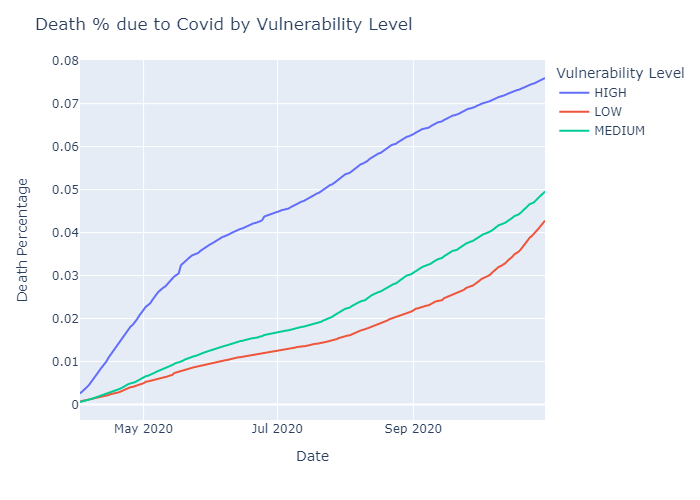

In [5]:
##### getting deaths due to covid and total population by vulnerability level and date

cov_agg = cov3.groupby(['VULNERA_LEVEL','date']).deaths.sum().reset_index()
cov_agg2 = cov3.groupby(['VULNERA_LEVEL','date']).population.sum().reset_index()
cov_agg3 = cov_agg.merge(cov_agg2,how='left', on=["VULNERA_LEVEL",'date'])
cov_agg3['death_percent'] = (cov_agg3['deaths']/cov_agg3['population'])*100

cov_agg3 = cov_agg3[(cov_agg3.date>'2020-04-01') & (cov_agg3.date<'2020-11-01')]

cov_agg3.rename(columns={'VULNERA_LEVEL' : 'Vulnerability Level'},inplace=True) 

fig = px.line(
  data_frame=cov_agg3,
  x = "date",
  y = "death_percent",
  color = "Vulnerability Level"
)


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Death Percentage',
    title='Death % due to Covid by Vulnerability Level',
    hovermode="x"
)

fig.show("png")